In [31]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.train.ensemble_trainer import make_trainer
from src.models import HNN, CHNN
from src.systems.chain_pendulum import ChainPendulum
from src.datasets import get_chaotic_eval_dataset

import warnings
warnings.filterwarnings('ignore')

def trace_plot(t, y, ax, y_std=None, min_y=-np.inf, max_y=np.inf,
               kind='region', color='black',
               plt_args=None):
    '''
    Arguments:
        zt: Assumes zeroth dimension is number of samples.
        ax: Matplotlib Axis
        pos: Positive quantity flag (for range bounds)
    '''
    assert kind in ['region', 'bound']
    plt_args = plt_args or dict()

    mu = np.mean(y, axis=0)
    std = np.std(y, axis=0) if y_std is None else y_std

    ax.plot(t, mu, c=color, **plt_args)

    if y.shape[0] == 1:
        return

    lower = np.clip(mu - 2. * std, min_y, max_y)
    upper = np.clip(mu + 2. * std, min_y, max_y)

    if kind == 'region':
        ax.fill_between(ts, lower, upper, color=color, alpha=0.2)
    elif kind == 'bound':
        ax.plot(np.array([t, t]).T, np.array([lower, upper]).T, c=color, dashes=[8,4])
    else:
        raise NotImplementedError

In [61]:
os.environ['DATADIR'] = '.'

cfg = {
    "num_bodies": 2,
    "lr": 3e-3,
    "tau": 10.0,
    "C": 5,
    "num_epochs": 5,
    "uq_type": "deep-ensemble",
    "device": 'cuda:0' if torch.cuda.is_available() else None
}

body = ChainPendulum(cfg['num_bodies'])
network = CHNN
trainer = make_trainer(**cfg, network=network, body=body)
trainer.train(cfg['num_epochs'])

n_init = 10
n_samples = 5
evald = get_chaotic_eval_dataset(body, n_init=n_init, n_samples=n_samples)

model = trainer.model.to(cfg['device'])
ts = evald['ts'].to(cfg['device'])
z0_orig = evald['z0_orig'].to(cfg['device'])

with torch.no_grad():
    pred_zt = trainer.model(z0_orig, ts).cpu()

ts = ts.cpu().numpy()
pred_zt = pred_zt.numpy()
true_zt = evald['true_zt'].numpy()
true_zt_chaos = evald['true_zt_chaos'].numpy()

Training ensemble member 0...


   Minibatch_Loss  Train_MAE    lr0  nfe  test_MAE
0        0.119926   0.121243  0.003  0.0  0.124934
    Minibatch_Loss  Train_MAE       lr0       nfe  test_MAE
15        0.053021   0.050139  0.000618  0.761905  0.048458

    Minibatch_Loss  Train_MAE       lr0  nfe  test_MAE
19             NaN   0.045775  0.000018  0.5  0.043348
Training ensemble member 1...


   Minibatch_Loss  Train_MAE    lr0  nfe  test_MAE
0        0.129115   0.126244  0.003  0.0  0.130731
    Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
11        0.051714    0.05159  0.0015  0.941176  0.049816

    Minibatch_Loss  Train_MAE       lr0  nfe  test_MAE
19             NaN   0.046435  0.000018  0.5  0.044423
Training ensemble member 2...


   Minibatch_Loss  Train_MAE    lr0  nfe  test_MAE
0         0.12207   0.122217  0.003  0.0  0.126303
    Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
11        0.046735   0.047341  0.0015  0.941176  0.045476

    Minibatch_Loss  Train_MAE       lr0  nfe  test_MAE
19             NaN   0.040848  0.000018  0.5  0.039313
Training ensemble member 3...


   Minibatch_Loss  Train_MAE    lr0  nfe  test_MAE
0        0.121898   0.121825  0.003  0.0  0.125784
    Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
11        0.048377   0.049078  0.0015  0.941176   0.04872

    Minibatch_Loss  Train_MAE       lr0  nfe  test_MAE
19             NaN   0.038297  0.000018  0.5  0.036355
Training ensemble member 4...


   Minibatch_Loss  Train_MAE    lr0  nfe  test_MAE
0        0.122192   0.120108  0.003  0.0   0.12315
    Minibatch_Loss  Train_MAE     lr0       nfe  test_MAE
11        0.053908   0.053866  0.0015  0.941176  0.053181

    Minibatch_Loss  Train_MAE       lr0  nfe  test_MAE
19             NaN   0.047197  0.000018  0.5   0.04628


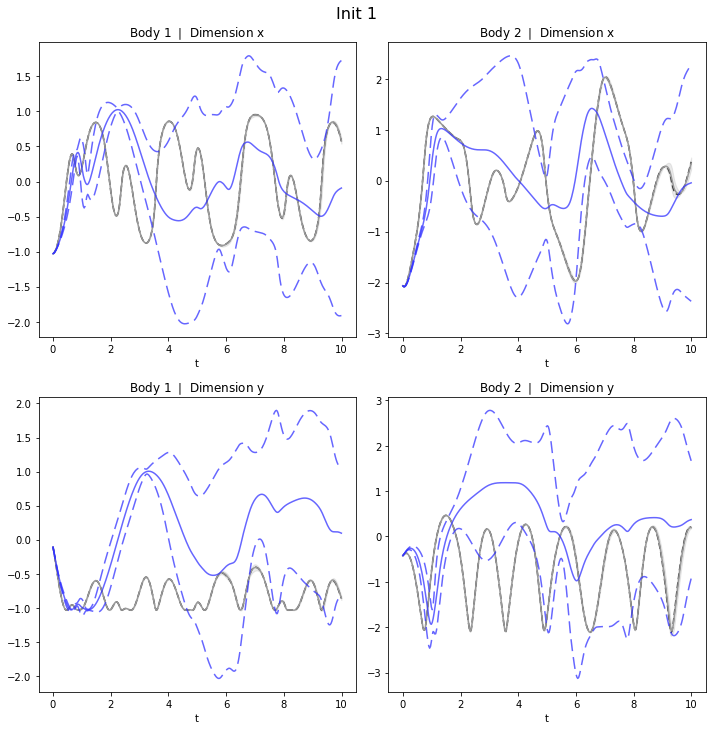

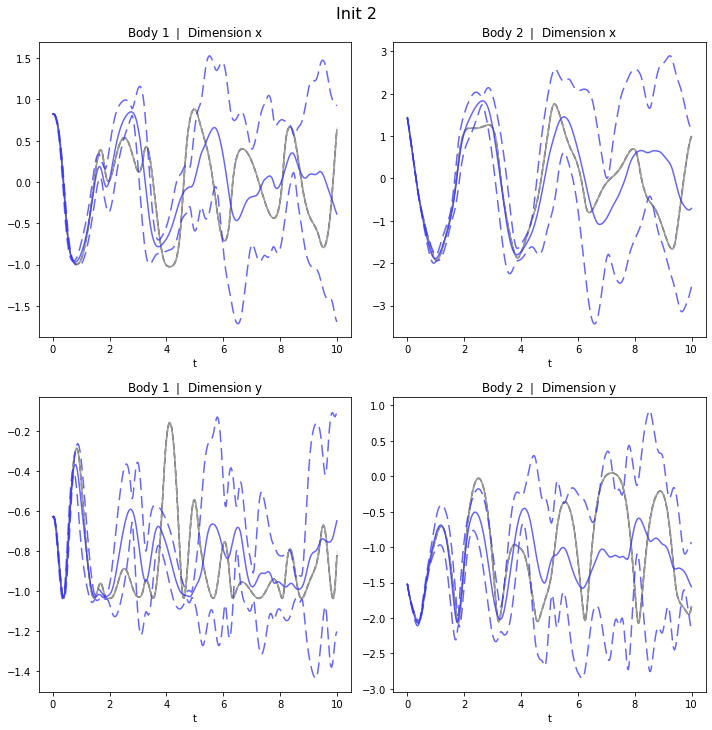

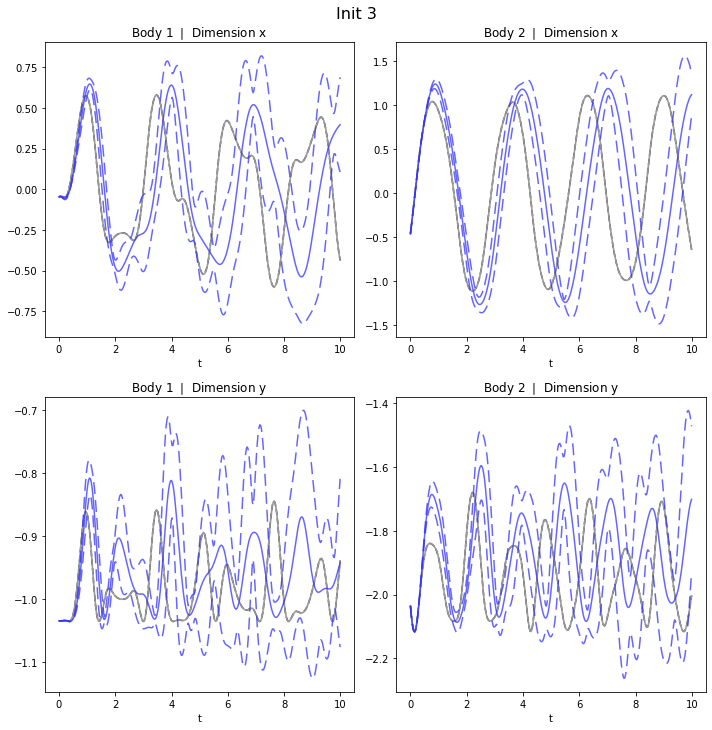

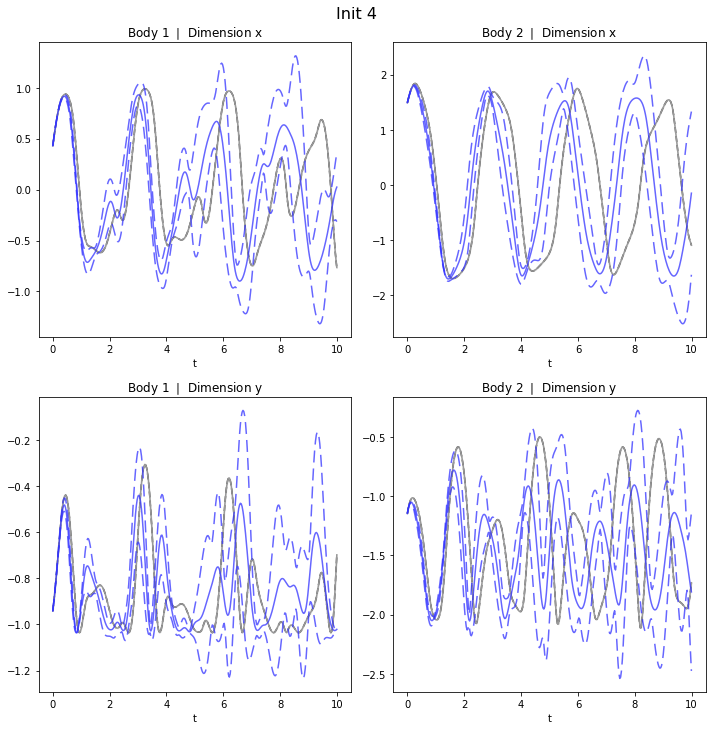

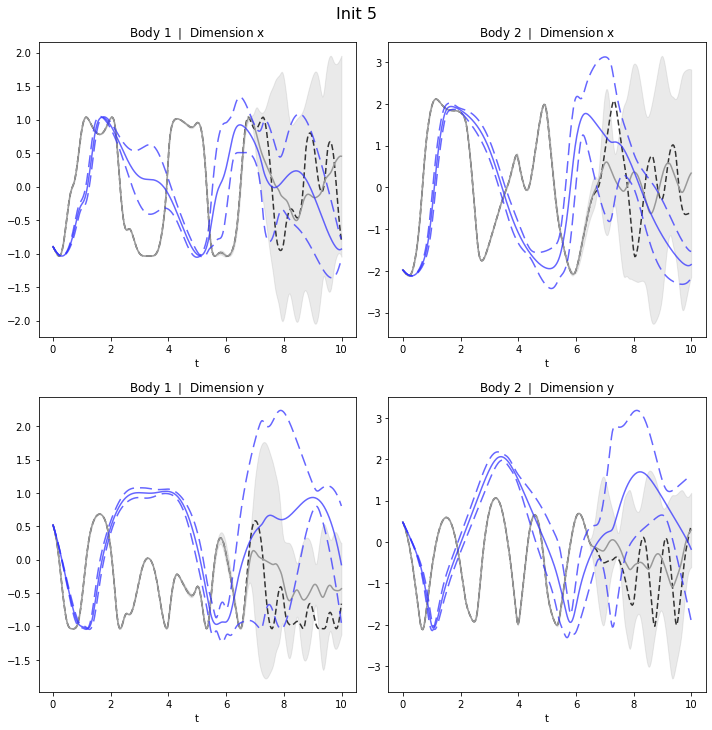

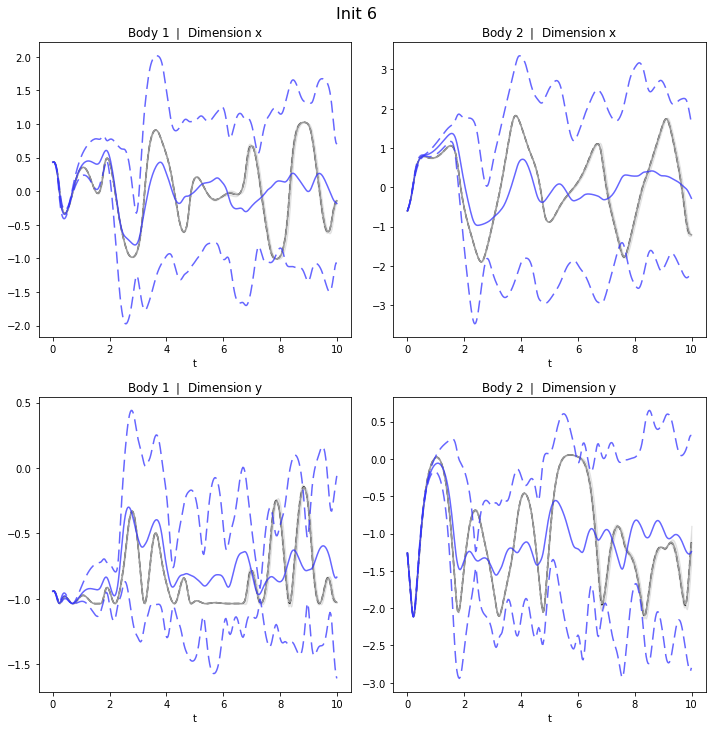

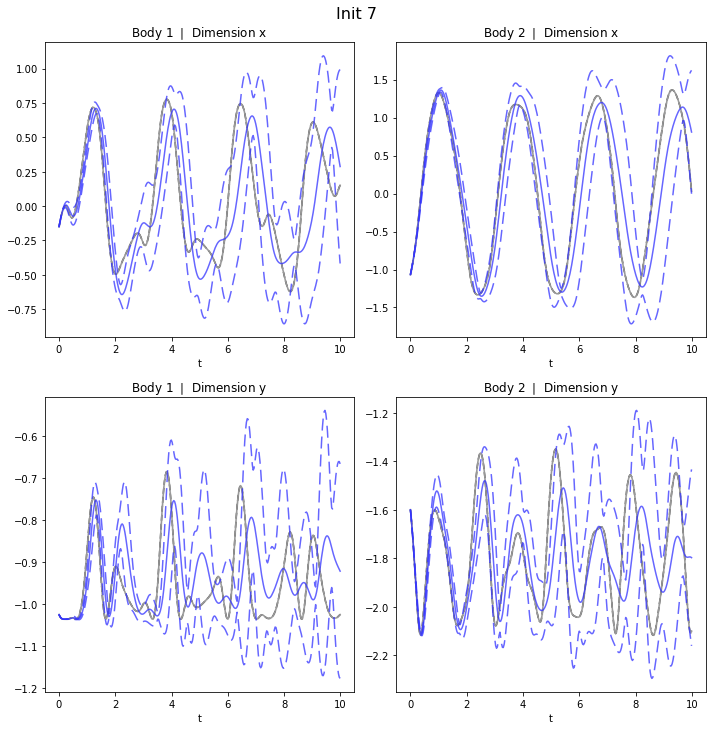

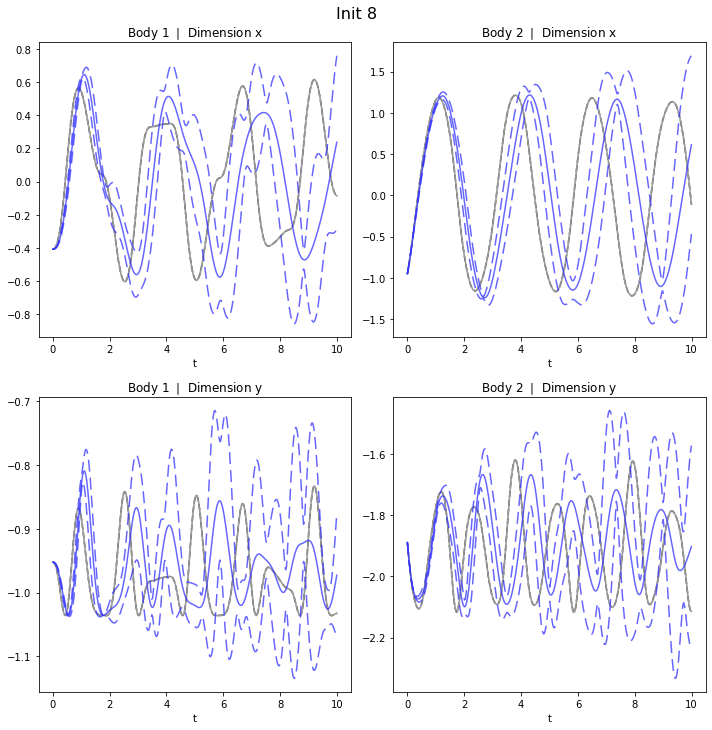

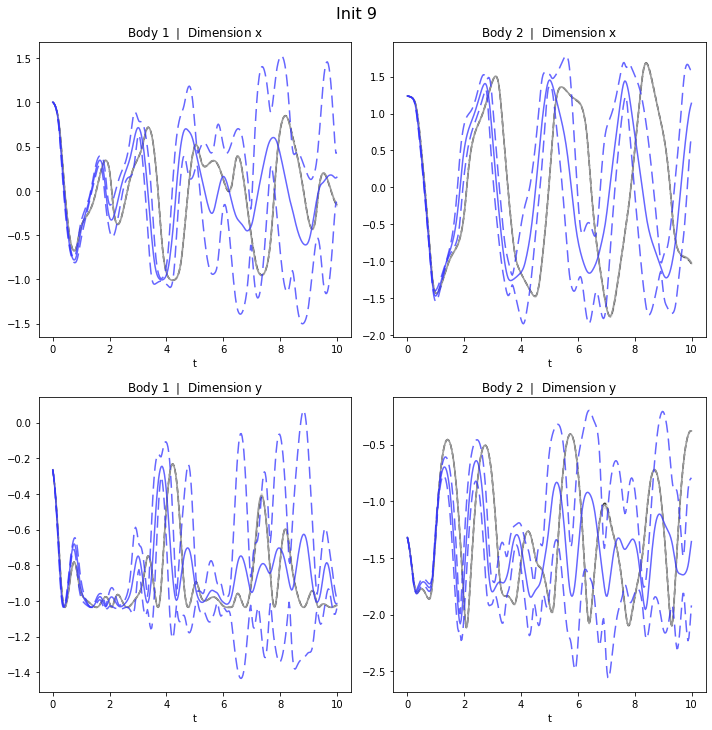

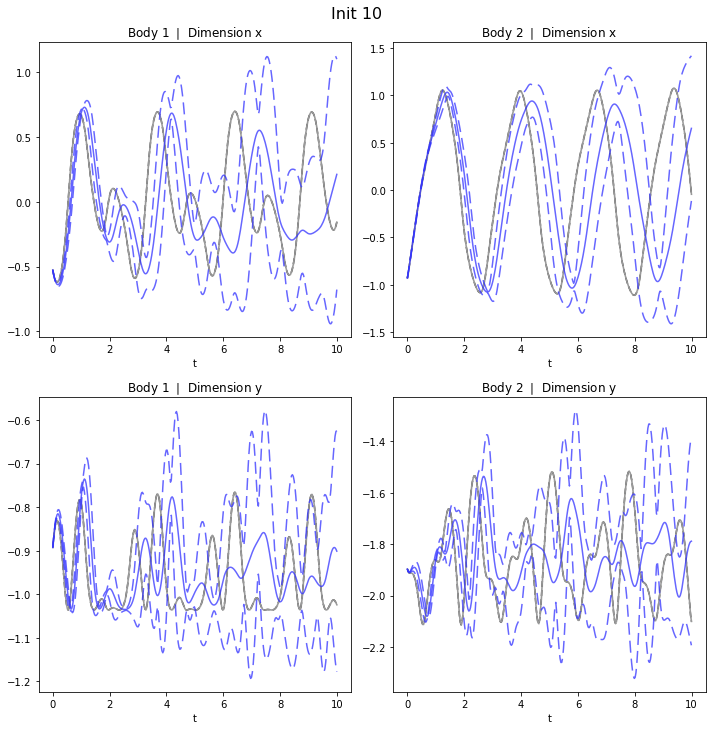

In [65]:
T, n_dof = ts.shape[-1], true_zt_chaos.shape[-1]
for init_id in range(n_init):
    
    fig, ax = plt.subplots(n_dof, cfg['num_bodies'], figsize=(10, 10))
    for b_id in range(cfg['num_bodies']):
        
        dof_label = ['x', 'y']
        for dof_id in range(n_dof):
            ax[dof_id, b_id].set_title(f'Body {b_id + 1} $\mid$ Dimension {dof_label[dof_id]}')
            ax[dof_id, b_id].set_xlabel('t')

            trace_plot(ts, true_zt[np.newaxis, init_id, :, 0, b_id, dof_id], ax[dof_id, b_id],
                       color=(.2,.2,.2), plt_args=dict(dashes=[4,2]))

            trace_plot(ts, true_zt_chaos[:, init_id, :, 0, b_id, dof_id], ax[dof_id, b_id],
                       color=(.6,.6,.6))

            trace_plot(ts, pred_zt[:, init_id, :, 0, b_id, dof_id], ax[dof_id, b_id], kind='bound', 
                       color=(.2,.2,1.,.75))

    fig.tight_layout()
    fig.suptitle(f'Init {init_id + 1}', fontsize=16, y=1.01)
    plt.show(fig)
    print("\n")